# Feature Extraction: Edges

# Table of Contents:


1.   Setup
2.   Load Data
3.   Quick EDA
4.   Feature Extraction: Edge Detection
5.   PCA
6.   Predictive Power
7.   TSNE (WIP)
8.   K Means (WIP)


## Setup

In [1]:
!pip install webdataset

In [2]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import feature
from skimage import data, exposure
from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import seaborn as sns



In [3]:
# paths
root = '/content/drive/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main/'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [5]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


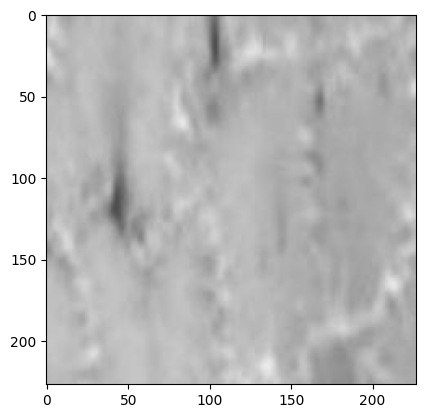

In [6]:
print(train_labels[0])
plt.imshow(train_images[0])

In [7]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8960, 227, 227, 3)
Shape of labels: (8960,)


## Quick EDA

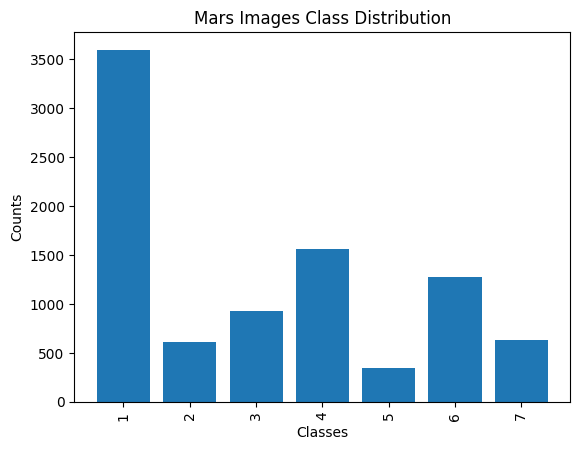

In [8]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

{1: 7, 2: 448, 3: 602, 4: 2478, 5: 35, 6: 1407, 7: 0}


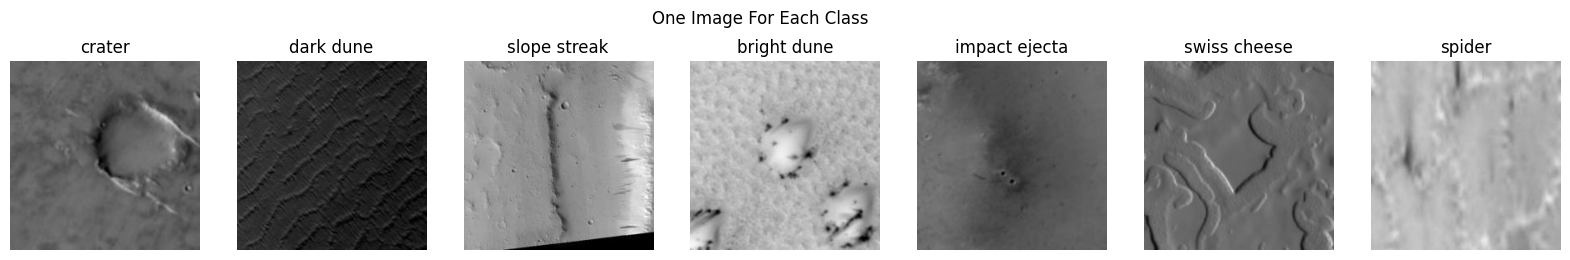

In [9]:
#show example of 1 of each class
label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
result = {}
unique_values = np.unique(train_labels)
for value in unique_values:
    indices = np.where(train_labels==value)[0][:1]
    result[value] = np.int_(indices)[0]
print(result)
#plotting first image for each class
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    #label_name = label_names[label]
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('One Image For Each Class')
plt.show()

## Feature Extraction: Edge Detection


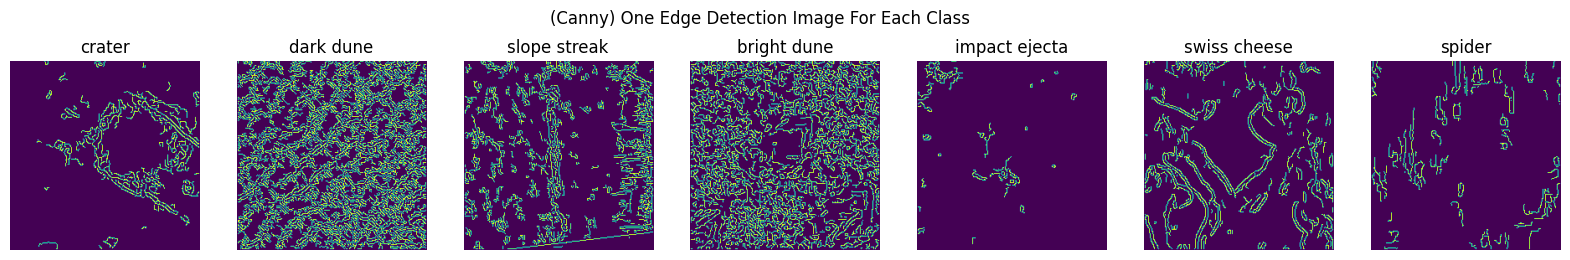

In [10]:
# Start with 1 example for each class for visualization, for each method
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    # To Do - Decide between edges detection Canny vs Difference of Gaussians
    canny_edges_image = feature.canny(image[:,:,0], sigma = 0.1) # Canny Edge Detection, requires 2-D matrix - Higher sigma = more blur/less noise, Lower sigma = less blur/more noise
    axs[i].imshow(canny_edges_image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('(Canny) One Edge Detection Image For Each Class')
plt.show()

# Examining DoG - Ended up deciding on Canny
#  # start with 1 example for each class for visualization, for each method
# fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
# i = 0
# for key, value in result.items():
#     image = train_images[value]
#     label = label_names[key-1]
#     # To Do - Decide between edges detection Canny vs Difference of Gaussians
#     dog_edges_image = filters.difference_of_gaussians(image[:,:,0], low_sigma = 1, high_sigma = 3) # difference of gaussians
#     axs[i].imshow(dog_edges_image)
#     axs[i].set_title(label)
#     axs[i].axis('off')
#     i += 1
# fig.suptitle('(DoG) One Edge Detection Image For Each Class')
# plt.show()

In [11]:
#apply to all, uses canny edge detection
def extract_edges_canny(img_dataset, sigma = 1.0):
    """
    Apply Canny edge detection for feature extraction to all images
    args: img_dataset (training / val / testing dataset)
    returns: img_dataset_canny_edges (dataset of canny edges)

    """
    img_dataset_canny_edges = []
    for img in img_dataset:
        canny_edges_image = feature.canny(image[:,:,0], sigma = 1.3)
        img_dataset_canny_edges.append(canny_edges_image)
    img_dataset_canny_edges = np.array(img_dataset_canny_edges)
    return img_dataset_canny_edges

In [12]:
simga = 0.5
train_images_canny_edges = extract_edges_canny(train_images, sigma = simga)
val_images_canny_edges = extract_edges_canny(val_images, sigma = simga)
test_images_canny_edges = extract_edges_canny(test_images, sigma = simga)

In [13]:
np.save(f'{feature_data_folder}/train_images_canny_edges.npy', train_images_canny_edges)
np.save(f'{feature_data_folder}/val_images_canny_edges.npy', val_images_canny_edges)
np.save(f'{feature_data_folder}/test_images_canny_edges.npy', test_images_canny_edges)


(8960, 227, 227)


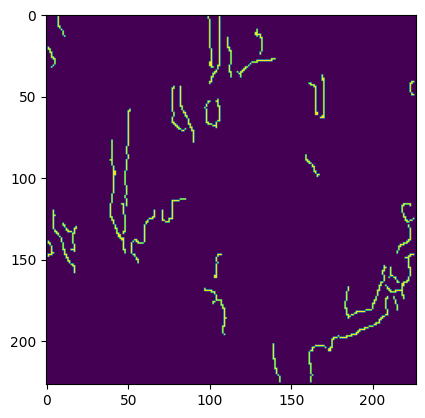

In [14]:
plt.imshow(train_images_canny_edges[0])
print(train_images_canny_edges.shape)

## PCA


In [15]:
# Flatten
train_images_canny_flat = train_images_canny_edges.reshape(train_images.shape[0], -1)
# val_images_canny_flat = val_images_canny_edges.reshape(val_images.shape[0], -1)
# test_images_canny_flat = test_images_canny_edges.reshape(test_images.shape[0], -1)
print(f'Flattened images shape: {train_images_canny_flat.shape}')

print(f"Mean: {train_images_canny_flat.mean()}")
print(f"Standard Deviation: {train_images_canny_flat.std()}")
print(f"Variance: {train_images_canny_flat.var()}")


Flattened images shape: (8960, 51529)
Mean: 0.021987618622523238
Standard Deviation: 0.1466429788630632
Variance: 0.021504163249832807


In [16]:
# Standardize
scaler = StandardScaler()
train_images_canny_flat_standardized = scaler.fit_transform(train_images_canny_flat)

# PCA
pca = PCA(n_components=100)
train_images_canny_pca = pca.fit_transform(train_images_canny_flat_standardized)
print(f'PCA shape: {train_images_canny_pca.shape}')

PCA shape: (8960, 100)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


## Predictive Power

In [17]:
clf = LogisticRegression().fit(train_images_canny_pca, train_labels)
clf.score(train_images_canny_pca, train_labels)



0.4015625

In [18]:
preds = clf.predict(train_images_canny_pca)
corr = preds == train_labels
df = pd.DataFrame({'correct': corr, 'label': train_labels})
df.head(50)


,correct,label
0,False,7
1,False,7
2,False,7
3,False,7
4,False,7
5,False,7
6,False,7
7,True,1
8,True,1
9,True,1


Text(0, 0.5, 'Count')

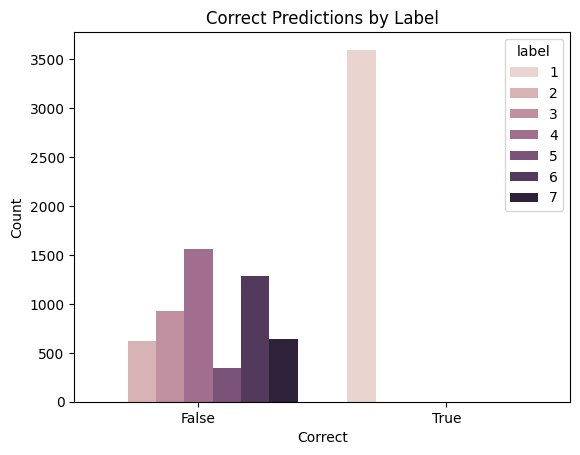

In [19]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

## TSNE

In [ ]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(train_images_canny_flat_standardized)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

## K Means
Doesn't work well for the binary numbers that make of the edges detected.

ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (7). Possibly due to duplicate points in X.

In [ ]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_lables = kmeans.fit_predict(train_images_canny_std)

kmeans_labels = kmeans.labels_
print(kmeans_labels)

centroids = kmeans.cluster_centers_
print(centroids)


# plt.figure(figsize=(10, 6))
# plt.scatter(train_images_canny_std[:,0], train_images_canny_std[:,1], c = kmeans_labels, cmap = 'viridis', s = 10)
# plt.title('Canny Edge Detection (Post PCA)')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()